In [18]:
import math
import copy  # 创建复合对象(包括列表、元组、字典和用户定义对象的实例)的深浅复制
import numpy as np


# 生成随机数据，5个高斯模型
def generate_data(sigma, N, mu1, mu2):
    global X  # 可观测数据集
    X = np.zeros((N, 2))  # 初始化X，N行2列。2维数据，N个样本
    X = np.mat(X)

    global mu  # 随机初始化mu1，mu2，mu3，mu4
    mu = np.random.random((5, 2))
    mu = np.mat(mu)

    global sigma_  # 随机初始化协方差矩阵
    sigma_ = np.repeat(np.expand_dims(np.eye(2)*20, axis=0), 5, axis=0)
    
    global alpha_  # 初始化混合项系数
    alpha_ = np.array([0.2, 0.2, 0.2, 0.2, 0.2])

    global excep  # 期望第i个样本属于第j个模型的概率的期望
    excep = np.zeros((N, 5))

    for i in range(N):
        if np.random.random(1) < 0.5:  # np.random.random()生成0-1之间随机数
            X[i, :] = np.random.multivariate_normal(mu1, sigma, 1)  # 用第一个高斯模型生成2维数据
            # np.random.multivariate_normal（mean,cov,size）返回服从多元正态分布的样本值
        else:
            X[i, :] = np.random.multivariate_normal(mu2, sigma, 1)  # 用第二个高斯模型生成2维数据


    #print("可观测数据：\n", X)  # 输出可观测样本
    print("初始化的均值：", mu)  # 输出初始化的mu
    print("初始化的协方差：", sigma_)  # 输出初始化的sigma_


# E步：计算后验概率（隐藏变量）
def e_step(k, N):
    global X
    global mu
    global sigma_
    global alpha_
    global excep

    for i in range(N):
        denom = 0
        for j in range(0, k):
            denom += alpha_[j] * np.exp(
                -(X[i, :] - mu[j, :]) * np.mat(np.linalg.pinv(sigma_[j])) * np.transpose(X[i, :] - mu[j, :]) / 2) / (
                                 np.sqrt(np.linalg.det(sigma_[j] + np.eye(2) * 0.001)))
        for j in range(0, k):
            numer = np.exp(-(X[i, :] - mu[j, :]) * np.mat(np.linalg.pinv(sigma_[j])) * np.transpose(X[i, :] - mu[j, :]) / 2) / (
                        np.sqrt(np.linalg.det(sigma_[j] + np.eye(2) * 0.001)))
            excep[i, j] = alpha_[j] * numer / denom

    #print("隐藏变量：\n", excep)


# M步：更新均值、协方差矩阵、混合项系数
def m_step(k, N):
    global X
    global mu
    global sigma_
    global alpha_
    global excep

    for j in range(0, k):
        denom = 0  # 分母
        numer1 = 0  # 均值的分子
        numer2 = 0  # 协方差的分子
        for i in range(N):
            numer1 += excep[i, j] * X[i, :]
            denom += excep[i, j]
        mu[j, :] = numer1 / denom  # 求均值
        alpha_[j] = denom / N  # 求混合项系数
        for i in range(N):
            numer2 += excep[i, j] * np.transpose(X[i, :] - mu[j, :]) * (X[i, :] - mu[j, :])
        sigma_[j] = numer2 / denom  # 求协方差


if __name__ == '__main__':  # 实现在程序/模块之间互相调用时声明一个运行界限的功能
    iter_num = 500  # 迭代次数
    N = 100  # 样本数目
    k = 5  # 高斯模型数
    # probility = np.zeros(N)    #混合高斯分布
    u1 = [5, 10]
    u2 = [30, 5]

    sigma = np.mat([[20, 10], [10, 20]])  # 协方差矩阵

    generate_data(sigma, N, u1, u2)  # 生成数据

    # 迭代计算
    for i in range(iter_num):
        err = 0  # 均值误差
        err_alpha = 0  # 混合项系数误差
        Old_mu = copy.deepcopy(mu)  # copy.deepcopy表示深复制
        Old_alpha = copy.deepcopy(alpha_)

        e_step(k, N)  # E步
        m_step(k, N)  # M步

        print("迭代次数:", i + 1)
        print("估计的均值:", mu)
        print("估计的协方差矩阵:", sigma_)
        print("估计的混合项系数:", alpha_)
        for z in range(k):
            err += (abs(Old_mu[z, 0] - mu[z, 0]) + abs(Old_mu[z, 1] - mu[z, 1]))  # 计算均值误差（即当前值与上一次迭代值的误差）
            err_alpha += abs(Old_alpha[z] - alpha_[z])  # 计算混合项系数误差
        if (err <= 0.001) and (err_alpha < 0.001):  # 达到精度退出迭代
            print(err, err_alpha)
            break

初始化的均值： [[0.44125681 0.81916809]
 [0.22161243 0.61317351]
 [0.23402254 0.85314835]
 [0.99753117 0.45415398]
 [0.59094624 0.27316787]]
初始化的协方差： [[[20.  0.]
  [ 0. 20.]]

 [[20.  0.]
  [ 0. 20.]]

 [[20.  0.]
  [ 0. 20.]]

 [[20.  0.]
  [ 0. 20.]]

 [[20.  0.]
  [ 0. 20.]]]
迭代次数: 1
估计的均值: [[15.57166363  8.92049918]
 [13.96986492  8.83698676]
 [13.83139723  9.19024888]
 [20.76139588  7.71854485]
 [17.48398291  7.92026361]]
估计的协方差矩阵: [[[168.7581029  -22.11312691]
  [-22.11312691  31.02723855]]

 [[161.97876201 -20.04073776]
  [-20.04073776  30.1692356 ]]

 [[159.51923575 -19.66808966]
  [-19.66808966  30.76643902]]

 [[165.89834687 -22.57409358]
  [-22.57409358  29.55725482]]

 [[174.43688715 -23.20638979]
  [-23.20638979  29.69938096]]]
估计的混合项系数: [0.20079954 0.15754256 0.17548038 0.28359562 0.18258191]
迭代次数: 2
估计的均值: [[15.55955161  8.94528336]
 [13.83013478  8.86749286]
 [13.6481943   9.26194978]
 [20.91804028  7.66295519]
 [17.54104629  7.88599422]]
估计的协方差矩阵: [[[168.54559932 -22.23978724

迭代次数: 17
估计的均值: [[18.98890034 10.33017765]
 [11.30168712  8.93640948]
 [ 4.79593516 10.91333725]
 [30.58665417  5.52811099]
 [20.58951872  6.34955169]]
估计的协方差矩阵: [[[ 86.52282781 -27.94150282]
  [-27.94150282  42.64909879]]

 [[122.43093371 -10.37520178]
  [-10.37520178  13.59664721]]

 [[ 14.5889935   13.08067541]
  [ 13.08067541  26.29151229]]

 [[ 15.85019022   8.54432203]
  [  8.54432203  20.04284668]]

 [[101.62902611 -14.40151813]
  [-14.40151813  19.75096233]]]
估计的混合项系数: [0.03957501 0.02584868 0.48181944 0.4159621  0.03679476]
迭代次数: 18
估计的均值: [[18.68460944 11.25388348]
 [10.74249124  8.95839218]
 [ 4.78846448 10.87040409]
 [30.50943267  5.53985229]
 [21.01131833  6.07969548]]
估计的协方差矩阵: [[[ 73.94881273 -32.71257459]
  [-32.71257459  47.43507062]]

 [[117.97941887 -10.45094515]
  [-10.45094515  11.56051991]]

 [[ 14.7732617   12.87069916]
  [ 12.87069916  25.89249044]]

 [[ 16.35227481   8.51619974]
  [  8.51619974  19.94973691]]

 [[ 90.36065258 -14.44907762]
  [-14.44907762  19.8

迭代次数: 34
估计的均值: [[ 9.72259309 19.81503105]
 [ 4.17250783 10.30862403]
 [ 4.60825666  9.83135558]
 [30.89371943  5.68011113]
 [22.67767733  3.86362064]]
估计的协方差矩阵: [[[15.46597777 -5.73837132]
  [-5.73837132  2.80837849]]

 [[21.01826172  1.46978688]
  [ 1.46978688  0.25092144]]

 [[13.09642943 13.19635609]
  [13.19635609 23.64101858]]

 [[13.4830085   7.4137391 ]
  [ 7.4137391  20.40484334]]

 [[ 4.24650141  3.77729715]
  [ 3.77729715  8.02291811]]]
估计的混合项系数: [0.05822313 0.11099007 0.36078718 0.42411946 0.04588017]
迭代次数: 35
估计的均值: [[ 9.72262767 19.81491455]
 [ 4.17175633 10.30790217]
 [ 4.60863082  9.83127355]
 [30.97787402  5.64298617]
 [22.75599364  4.34226097]]
估计的协方差矩阵: [[[15.46512457 -5.7381313 ]
  [-5.7381313   2.80844234]]

 [[20.99005972  1.46839638]
  [ 1.46839638  0.25149338]]

 [[13.10103656 13.20193657]
  [13.20193657 23.65120195]]

 [[12.96927385  7.65565957]
  [ 7.65565957 20.54419728]]

 [[ 4.22555769  4.77323078]
  [ 4.77323078  9.22436288]]]
估计的混合项系数: [0.05822693 0.11115

迭代次数: 51
估计的均值: [[ 9.72260663 19.8147022 ]
 [ 4.16897816 10.30530989]
 [ 4.61019927  9.83142996]
 [31.19689102  5.34714685]
 [23.90882213  6.37352512]]
估计的协方差矩阵: [[[15.46356598 -5.73789883]
  [-5.73789883  2.80870594]]

 [[20.89327281  1.46359445]
  [ 1.46359445  0.25352247]]

 [[13.11787604 13.22247775]
  [13.22247775 23.68867979]]

 [[12.39031945  9.14935602]
  [ 9.14935602 20.00253195]]

 [[ 7.80053444 10.3785069 ]
  [10.3785069  15.70806531]]]
估计的混合项系数: [0.05822463 0.11171762 0.36005799 0.39872654 0.07127323]
迭代次数: 52
估计的均值: [[ 9.7226062  19.8147026 ]
 [ 4.16896507 10.30529793]
 [ 4.61020756  9.83143232]
 [31.19651875  5.34712101]
 [23.90855438  6.37400085]]
估计的协方差矩阵: [[[15.46357742 -5.7379038 ]
  [-5.7379038   2.8087074 ]]

 [[20.89283379  1.46357259]
  [ 1.46357259  0.25353187]]

 [[13.11795689 13.22257721]
  [13.22257721 23.68885927]]

 [[12.39213001  9.14916557]
  [ 9.14916557 20.00174733]]

 [[ 7.80215274 10.3812981 ]
  [10.3812981  15.71043414]]]
估计的混合项系数: [0.05822455 0.11172

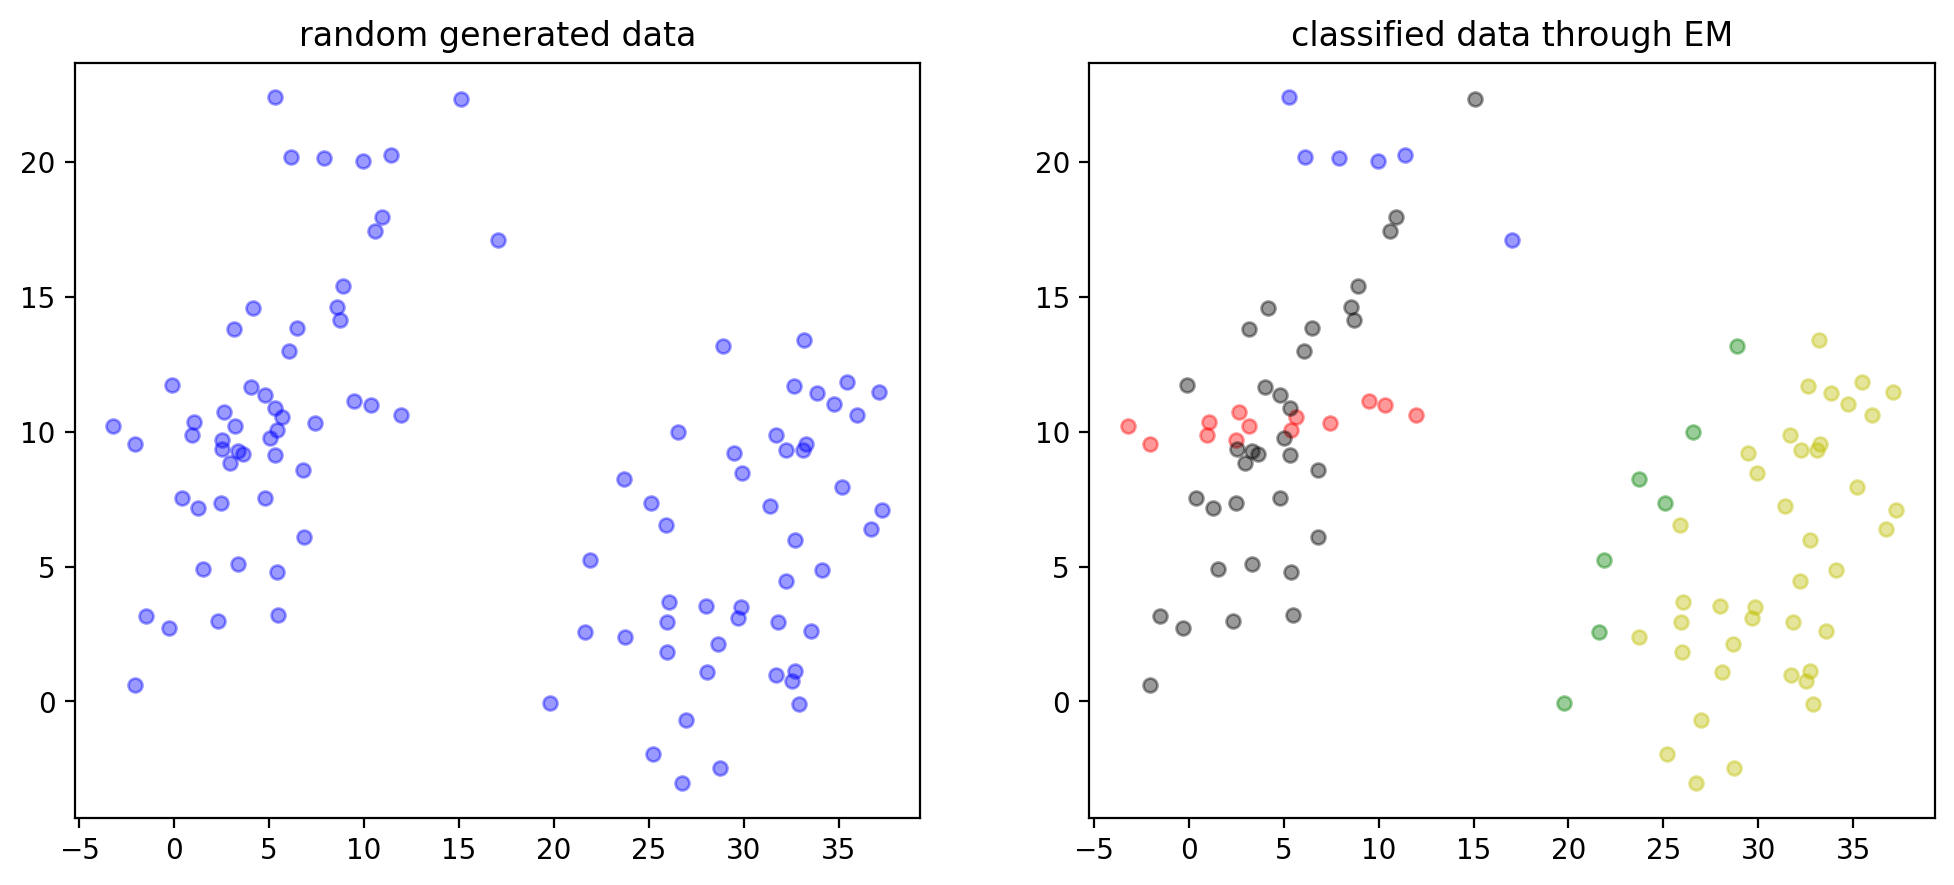

In [19]:
import matplotlib.pyplot as plt
probility = np.zeros(N)    #混合高斯分布
#可视化结果
# 画生成的原始数据
plt.figure(figsize=(12,5),dpi=200)
plt.subplot(121)
plt.scatter(X[:,0].tolist(), X[:,1].tolist(),c='b',s=25,alpha=0.4,marker='o')    #T散点颜色，s散点大小，alpha透明度，marker散点形状
plt.title('random generated data')
#画分类好的数据
plt.subplot(122)
plt.title('classified data through EM')
order=np.zeros(N)
color=['b','r','k','y','g']
for i in range(N):
    for j in range(k):
        if excep[i,j]==max(excep[i,:]):
            order[i]=j     #选出X[i,:]属于第几个高斯模型
        probility[i] += alpha_[int(order[i])]*math.exp(-(X[i,:]-mu[j,:])*np.mat(sigma_[j] + np.eye(2) * 0.0001).I*np.transpose(X[i,:]-mu[j,:]))/(np.sqrt(np.linalg.det(sigma))*2*np.pi)    #计算混合高斯分布
    plt.scatter(X[i, 0], X[i, 1], c=color[int(order[i])], s=25, alpha=0.4, marker='o')      #绘制分类后的散点图
for j in range(k):
    plt.plot(mu[k,0]+X(:,0),mu())
    #绘制三维图像
plt.show()